In [ ]:
%load functions.py

evolving generation 0 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel

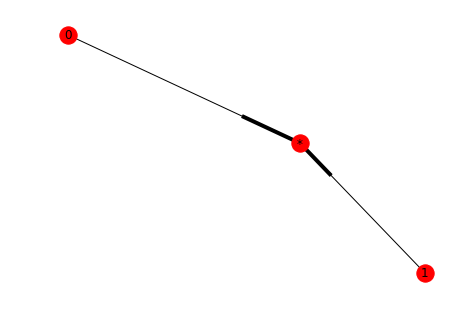

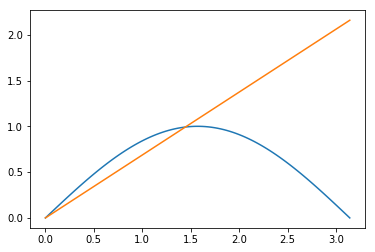

min error at generation n.0: 20.1343583839
evolving generation 1 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


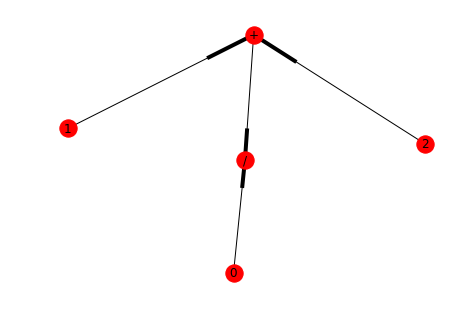

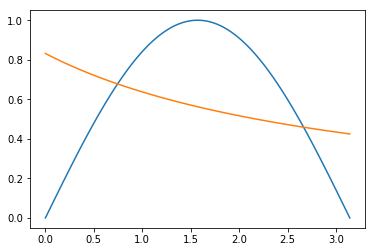

min error at generation n.1: 13.8778391029
evolving generation 2 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract


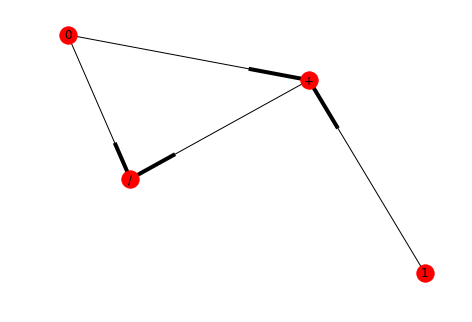

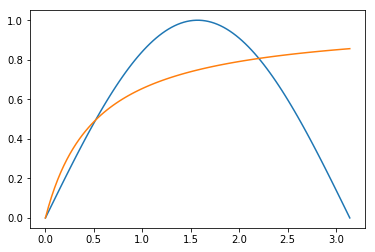

min error at generation n.2: 14.0208724569
evolving generation 3 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract


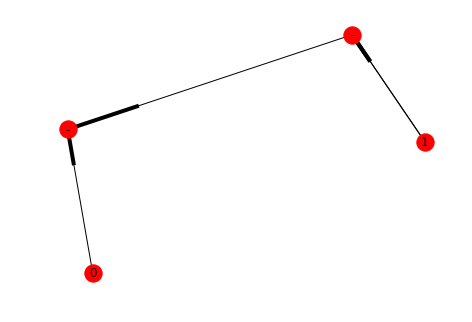

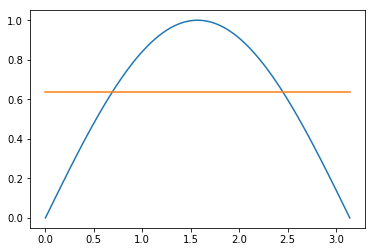

min error at generation n.3: 10.0874665389
evolving generation 4 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


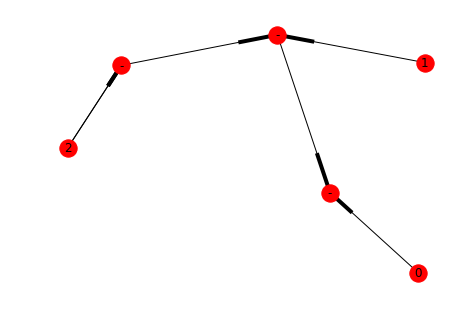

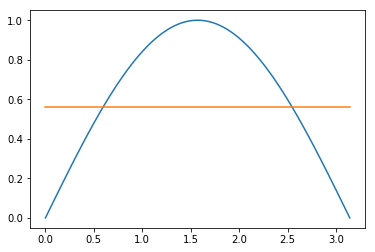

min error at generation n.4: 10.2294524372
evolving generation 5 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


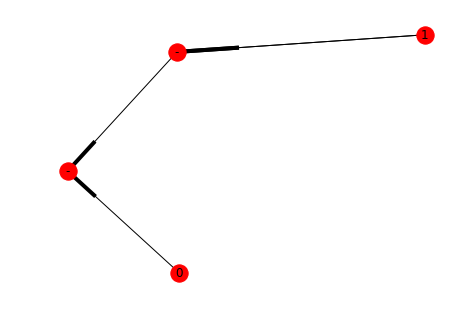

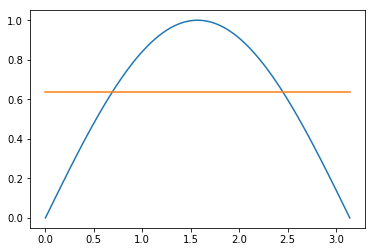

min error at generation n.5: 10.0537919907
evolving generation 6 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract


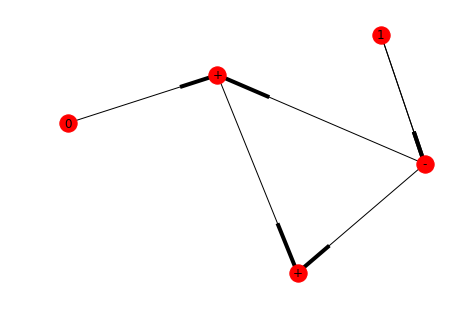

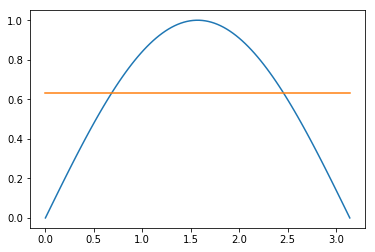

min error at generation n.6: 10.1839754574
evolving generation 7 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


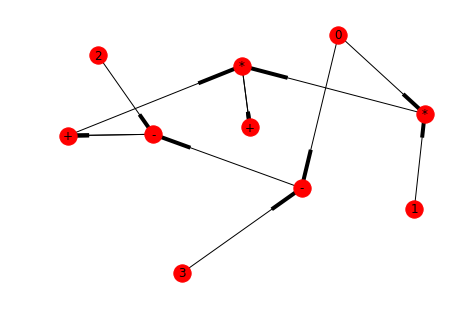

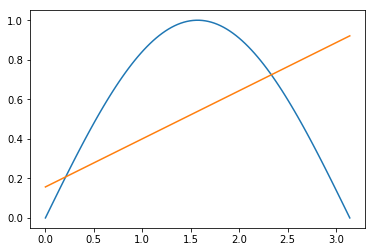

min error at generation n.7: 7.54869537746
evolving generation 8 of 20


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in subtract
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


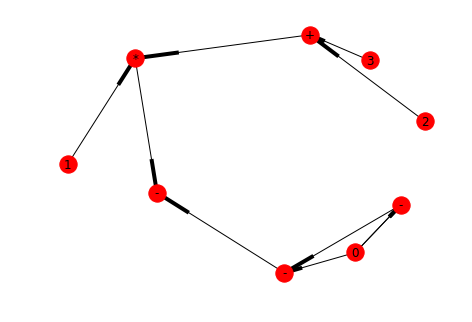

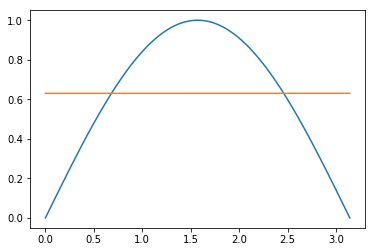

min error at generation n.8: 10.4994230398
evolving generation 9 of 20


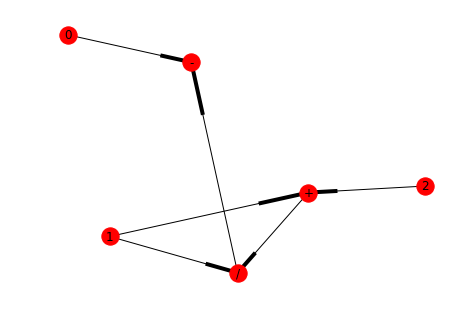

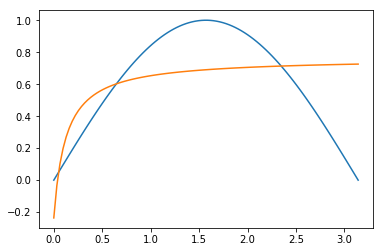

min error at generation n.9: 7.94393384637


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


{'specimen': [{'lib_id': 0, 'input': [], 'arg_index': 0}, {'lib_id': 1, 'input': [2, 0]}, {'lib_id': 3, 'input': [4, 0]}, {'lib_id': 0, 'input': [], 'arg_index': 1}, {'lib_id': 3, 'input': [0, 3]}], 'error': 1.4384333324732921}
fittest specimen:


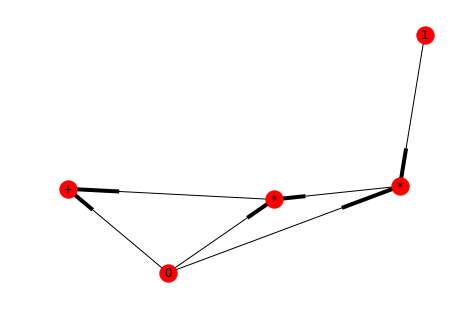

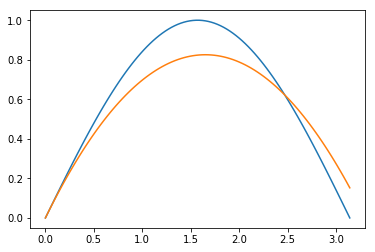

In [5]:
#GRAPH STRUCTURE OPTIMIZATION TEST
x = np.linspace(0,math.pi,100)
y = np.sin(x)#2*x + 1
data = {"x":x,"y":y}
e = evolution(data)
print(e)
print("fittest specimen:")
draw(e["specimen"])
plot_optimized(e["specimen"],data)

{'X': 0, 'parameters': array([ 0.51636347,  1.99875824]), 'iterations': 43, 'error': 0.0052437080221526718}


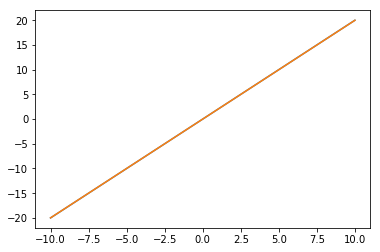

In [21]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
result = optimize(lib[7]["graph"],data,0)
print(result)
values = result["parameters"]
x_pos = result["X"]
#input_size*number_of_data_points matrix that contains a list of input vectors like [parameter1, parameter2, x_value, ...]
value_matrix = [[(xe if v == x_pos else value) for v, value in enumerate(values)] for xe in x]
y = np.array([ eval(lib[7]["graph"],value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)
pylab.show()

/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

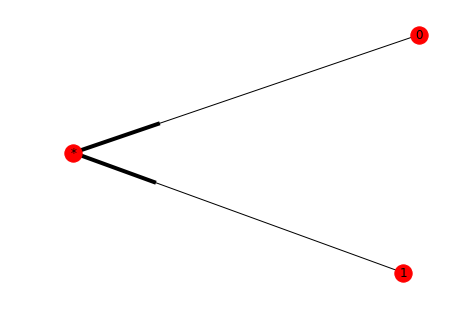

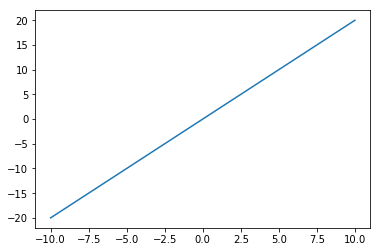

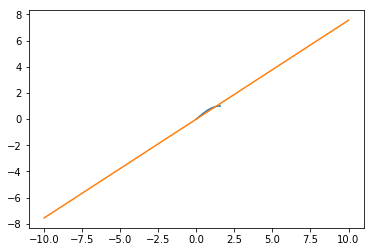

In [382]:
draw(lib[7]["graph"])
plot_specimen(lib[7]["graph"],[2,2])
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
plot_optimized(lib[7]["graph"],data)

/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

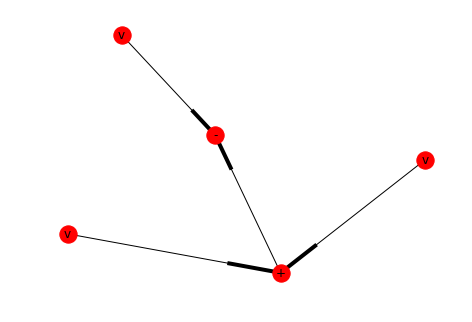

reference update: 


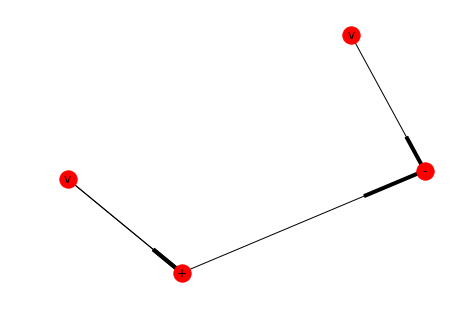

In [327]:
g3 = insert_at(lib[5]["graph"],lib[6]["graph"])
draw(g3)
g4 = merge_input_entries(g3)
draw(g4)

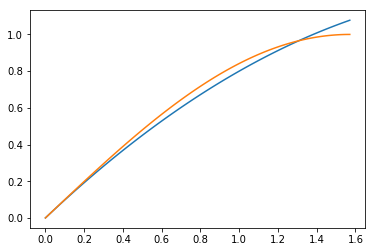

In [386]:
pylab.close()
x = np.linspace(0,math.pi/2,100)
y = x-0.2*x**2
pylab.plot(x,y)
y = np.sin(x)
pylab.plot(x,y)
pylab.show()